# 02 – Control de calidad (QC) del objeto principal `.h5ad`

Notebook de QC inicial del dataset principal de scRNA-seq (TFM en cirrosis).  
Carga el `.h5ad`, calcula métricas básicas por célula, aplica filtros técnicos y guarda un objeto filtrado para los siguientes pasos (normalización, HVG, integración).

## 1. Contexto de los datos y supuestos de partida

- Datos en `TFM_CIRRHOSIS_merged.h5ad` (AnnData: células × genes).
- `adata.X` se interpreta como **raw counts** o cercano a counts.
- Este notebook:
  - **no** normaliza ni integra,
  - solo hace QC técnico por célula (genes, counts, % mitocondrial).
- La información clínica y de Scrublet viene del merge previo y se conserva.

In [1]:
from pathlib import Path
import json

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

print("Scanpy:", sc.__version__)
print("AnnData:", ad.__version__)

Scanpy: 1.11.5
AnnData: 0.12.6


C:\Users\Coni\AppData\Local\Temp\ipykernel_14856\1154666483.py:9: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("Scanpy:", sc.__version__)
C:\Users\Coni\AppData\Local\Temp\ipykernel_14856\1154666483.py:10: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  print("AnnData:", ad.__version__)


## 2. Organización provisional de carpetas y localización de los datos

- Se asume este notebook en `notebooks/` y se define:
  - `PROJECT_ROOT`, `AI_PACKAGE_DIR`, `DATA_RAW_DIR`, `DATA_PROCESSED_DIR`.
- Se lee `AI_Package/MANIFEST.json` (si existe) para recuperar claves estándar.
- Se construye `CONFIG` con:
  - rutas (`RAW_H5AD_PATH = data_raw/TFM_CIRRHOSIS_merged.h5ad`),
  - claves `EMB_KEY`, `NBR_KEY`, `UMAP_KEY`.
- Se crea `data_processed/` si no existe.

In [2]:
# Detectamos la carpeta raíz del proyecto asumiendo que este notebook está en "notebooks/"
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

AI_PACKAGE_DIR = PROJECT_ROOT / "AI_Package"
DATA_RAW_DIR   = PROJECT_ROOT / "data_raw"
DATA_PROCESSED_DIR = PROJECT_ROOT / "data_processed"  # para guardar salidas de QC y pasos posteriores
DATA_PROCESSED_DIR.mkdir(exist_ok=True)

print("Directorio del notebook:", NOTEBOOK_DIR)
print("Raíz del proyecto:", PROJECT_ROOT)
print("Carpeta AI_Package:", AI_PACKAGE_DIR)
print("Carpeta data_raw:", DATA_RAW_DIR)
print("Carpeta data_processed:", DATA_PROCESSED_DIR)

# Leemos MANIFEST.json para recuperar claves estándar si está disponible
manifest_path = AI_PACKAGE_DIR / "MANIFEST.json"
if manifest_path.exists():
    with open(manifest_path, "r", encoding="utf-8") as f:
        manifest = json.load(f)
else:
    manifest = {}
    print("\n[AVISO] No se ha encontrado MANIFEST.json; se usarán valores por defecto.")

# Configuración del pipeline (claves estándar y rutas principales)
CONFIG = {
    "PROJECT_ROOT": PROJECT_ROOT,
    "AI_PACKAGE_DIR": AI_PACKAGE_DIR,
    "DATA_RAW_DIR": DATA_RAW_DIR,
    "DATA_PROCESSED_DIR": DATA_PROCESSED_DIR,
    "RAW_H5AD_PATH": DATA_RAW_DIR / "TFM_CIRRHOSIS_merged.h5ad",
    "EMB_KEY": manifest.get("keys", {}).get("EMB_KEY", "X_pca_harmony"),
    "NBR_KEY": manifest.get("keys", {}).get("NBR_KEY", "harmony"),
    "UMAP_KEY": manifest.get("keys", {}).get("UMAP_KEY", "X_umap_harmony"),
}

CONFIG

Directorio del notebook: D:\Users\Coni\Documents\TFM_CirrhosIS\notebooks
Raíz del proyecto: D:\Users\Coni\Documents\TFM_CirrhosIS
Carpeta AI_Package: D:\Users\Coni\Documents\TFM_CirrhosIS\AI_Package
Carpeta data_raw: D:\Users\Coni\Documents\TFM_CirrhosIS\data_raw
Carpeta data_processed: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed


{'PROJECT_ROOT': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS'),
 'AI_PACKAGE_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/AI_Package'),
 'DATA_RAW_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_raw'),
 'DATA_PROCESSED_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_processed'),
 'RAW_H5AD_PATH': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_raw/TFM_CIRRHOSIS_merged.h5ad'),
 'EMB_KEY': 'X_pca_harmony',
 'NBR_KEY': 'harmony',
 'UMAP_KEY': 'X_umap_harmony'}

## 3. Carga del objeto `.h5ad` y primeras inspecciones

- Se comprueba que `RAW_H5AD_PATH` existe y se carga con `sc.read_h5ad`.
- Se muestran:
  - dimensiones del AnnData,
  - columnas disponibles en `adata.obs` y `adata.var`,
  - primeras filas de `adata.obs`.
- Se inspecciona `adata.X`:
  - tipo (matriz densa/dispersa),
  - rango de valores (mínimo, máximo),
  - comprobación de valores **enteros** para confirmar que son counts.
- Se calculan `total_counts_from_X` y `n_genes_from_X` y se comparan con
  `nCount_RNA` y `nFeature_RNA` para verificar que el mapeo desde Seurat es coherente.

In [3]:
raw_h5ad_path = CONFIG["RAW_H5AD_PATH"]

if not raw_h5ad_path.exists():
    raise FileNotFoundError(
        f"No se encuentra el archivo principal .h5ad en:\n{raw_h5ad_path}\n"
        "Asegúrate de que la ruta es correcta o modifica CONFIG['RAW_H5AD_PATH']."
    )

# Carga del objeto AnnData
adata = sc.read_h5ad(raw_h5ad_path)
print(adata)

AnnData object with n_obs × n_vars = 231953 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet'
    var: 'features'


In [4]:
# Mostramos algunas columnas de obs (metadatos por célula)
print("Columnas disponibles en adata.obs:")
print(list(adata.obs.columns))

# Mostramos algunas columnas de var (metadatos por gen)
print("\nColumnas disponibles en adata.var:")
print(list(adata.var.columns))

# Vistazo rápido a las primeras filas de obs
adata.obs.head()

Columnas disponibles en adata.obs:
['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet']

Columnas disponibles en adata.var:
['features']


,orig.ident,nCount_RNA,nFeature_RNA,gem_id,patientID,age,sex,diagnostic,disease,disease_classification,disease_status,disease_grade,alternative_classification,comorbidity,sample_collection,scrublet_doublet_scores,scrublet_predicted_doublet
hner8v5o_m8skafb5_AAACCCAAGAACGTGC-1,SeuratProject,6747,2316,hner8v5o_m8skafb5,CNAG_117,60,male,Cirrosis x OH,Cirrhosis,ALD,Inactive,g2,Decompensated-Compensated,NA,OPD,NA,NA
hner8v5o_m8skafb5_AAACCCAAGACCAACG-1,SeuratProject,11912,3750,hner8v5o_m8skafb5,CNAG_117,60,male,Cirrosis x OH,Cirrhosis,ALD,Inactive,g2,Decompensated-Compensated,NA,OPD,NA,NA
hner8v5o_m8skafb5_AAACCCAAGCAATAGT-1,SeuratProject,11265,3371,hner8v5o_m8skafb5,CNAG_117,60,male,Cirrosis x OH,Cirrhosis,ALD,Inactive,g2,Decompensated-Compensated,NA,OPD,NA,NA
hner8v5o_m8skafb5_AAACCCAAGCATTGAA-1,SeuratProject,11504,4007,hner8v5o_m8skafb5,CNAG_117,60,male,Cirrosis x OH,Cirrhosis,ALD,Inactive,g2,Decompensated-Compensated,NA,OPD,NA,NA
hner8v5o_m8skafb5_AAACCCAAGCCGTTAT-1,SeuratProject,5011,2377,hner8v5o_m8skafb5,CNAG_117,60,male,Cirrosis x OH,Cirrhosis,ALD,Inactive,g2,Decompensated-Compensated,NA,OPD,NA,NA


In [5]:
from scipy.sparse import issparse

# Comprobamos el tipo de datos de la matriz de expresión
X = adata.X

print("Tipo de objeto para adata.X:", type(X))

# Tomamos una pequeña porción para inspeccionar
sub = X[:100, :100]

# Si es matriz dispersa, la convertimos explícitamente a denso
if issparse(sub):
    sub = sub.toarray()

# Aseguramos que es un array NumPy de floats
sample_values = np.asarray(sub, dtype=float)

print("Mínimo en sample_values:", float(sample_values.min()))
print("Máximo en sample_values:", float(sample_values.max()))

# Comprobamos si mayoritariamente hay enteros (cuentas)
is_integer_like = np.allclose(sample_values, np.round(sample_values), atol=1e-8)
print("¿Valores mayoritariamente enteros (como cuentas)?", bool(is_integer_like))

Tipo de objeto para adata.X: <class 'scipy.sparse._csr.csr_matrix'>
Mínimo en sample_values: 0.0
Máximo en sample_values: 15.0
¿Valores mayoritariamente enteros (como cuentas)? True


In [6]:
from scipy.sparse import issparse

# Calculamos total de counts y nº de genes detectados por célula a partir de adata.X
X = adata.X

if issparse(X):
    counts_per_cell = np.ravel(X.sum(axis=1))
    genes_per_cell = np.ravel((X > 0).sum(axis=1))
else:
    counts_per_cell = np.ravel(X.sum(axis=1))
    genes_per_cell = np.ravel((X > 0).sum(axis=1))

adata.obs["total_counts_from_X"] = counts_per_cell
adata.obs["n_genes_from_X"] = genes_per_cell

print("Comparación nCount_RNA vs total_counts_from_X (primeras 5 filas):")
print(
    adata.obs[["nCount_RNA", "total_counts_from_X"]]
    .head()
)

print("\nComparación nFeature_RNA vs n_genes_from_X (primeras 5 filas):")
print(
    adata.obs[["nFeature_RNA", "n_genes_from_X"]]
    .head()
)

Comparación nCount_RNA vs total_counts_from_X (primeras 5 filas):
                                     nCount_RNA  total_counts_from_X
hner8v5o_m8skafb5_AAACCCAAGAACGTGC-1       6747               6747.0
hner8v5o_m8skafb5_AAACCCAAGACCAACG-1      11912              11912.0
hner8v5o_m8skafb5_AAACCCAAGCAATAGT-1      11265              11265.0
hner8v5o_m8skafb5_AAACCCAAGCATTGAA-1      11504              11504.0
hner8v5o_m8skafb5_AAACCCAAGCCGTTAT-1       5011               5011.0

Comparación nFeature_RNA vs n_genes_from_X (primeras 5 filas):
                                     nFeature_RNA  n_genes_from_X
hner8v5o_m8skafb5_AAACCCAAGAACGTGC-1         2316            2316
hner8v5o_m8skafb5_AAACCCAAGACCAACG-1         3750            3750
hner8v5o_m8skafb5_AAACCCAAGCAATAGT-1         3371            3371
hner8v5o_m8skafb5_AAACCCAAGCATTGAA-1         4007            4007
hner8v5o_m8skafb5_AAACCCAAGCCGTTAT-1         2377            2377


## 4. Cálculo de métricas de QC por célula

- Se definen genes mitocondriales humanos como var_names que empiezan por `"MT-"`.
- Se guarda la máscara `adata.var["mt"]`.
- Con `sc.pp.calculate_qc_metrics(..., qc_vars=["mt"])` se añaden a `adata.obs`:
  - `total_counts`,
  - `n_genes_by_counts`,
  - `pct_counts_mt`.
- Se generan violin plots y scatter plots de estas métricas para inspección
  visual de outliers (baja señal, %MT alto, etc.).

In [7]:
# Aseguramos que los var_names contienen símbolos de gen;
# si tus símbolos están en otra columna (por ejemplo 'gene_symbol'), adapta esta parte.
gene_names = adata.var_names

# Creamos un booleano para genes mitocondriales (humanos: empiezan por "MT-")
mt_genes = gene_names.str.upper().str.startswith("MT-")
print(f"Número de genes mitocondriales detectados: {mt_genes.sum()}")

# Guardamos la máscara como columna en adata.var
adata.var["mt"] = mt_genes.astype(bool)

# Calculamos métricas estándar de QC con scanpy
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],   # usamos el nombre de la columna
    inplace=True
)

# Comprobamos qué columnas nuevas se han añadido a adata.obs
[qc_col for qc_col in adata.obs.columns
 if "n_genes" in qc_col or "total_counts" in qc_col or "pct_counts" in qc_col]

Número de genes mitocondriales detectados: 13


['total_counts_from_X',
 'n_genes_from_X',
 'n_genes_by_counts',
 'log1p_n_genes_by_counts',
 'total_counts',
 'log1p_total_counts',
 'pct_counts_in_top_50_genes',
 'pct_counts_in_top_100_genes',
 'pct_counts_in_top_200_genes',
 'pct_counts_in_top_500_genes',
 'total_counts_mt',
 'log1p_total_counts_mt',
 'pct_counts_mt']

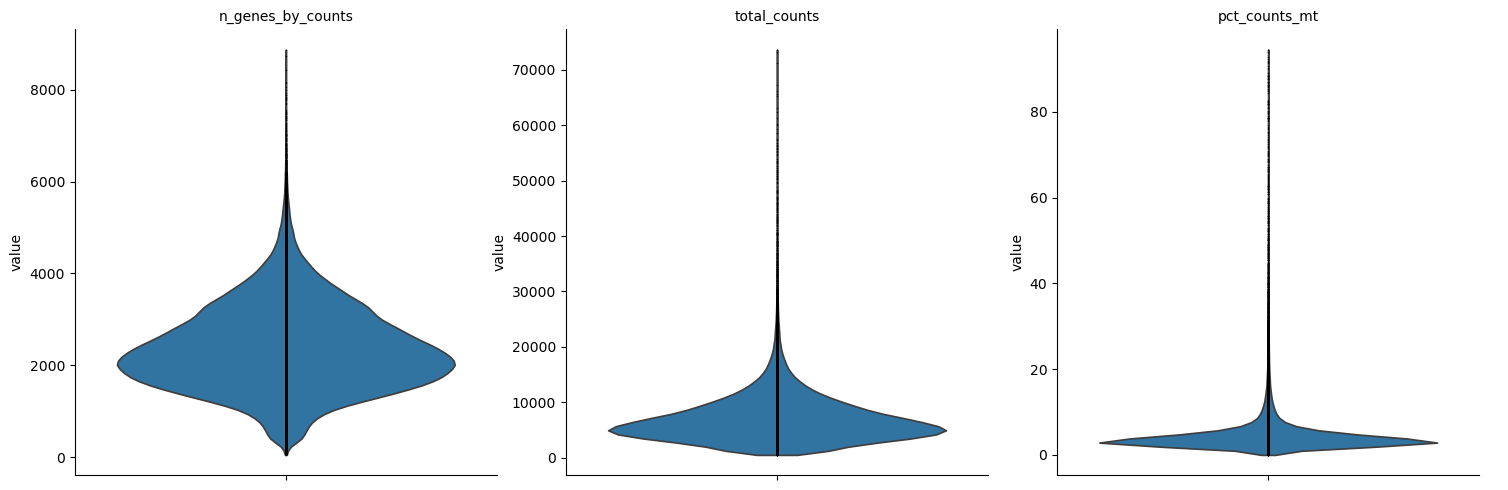

In [8]:
# Violin plots de métricas de QC básicas (sin jitter y usando todas las células)
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.0,
    multi_panel=True
)

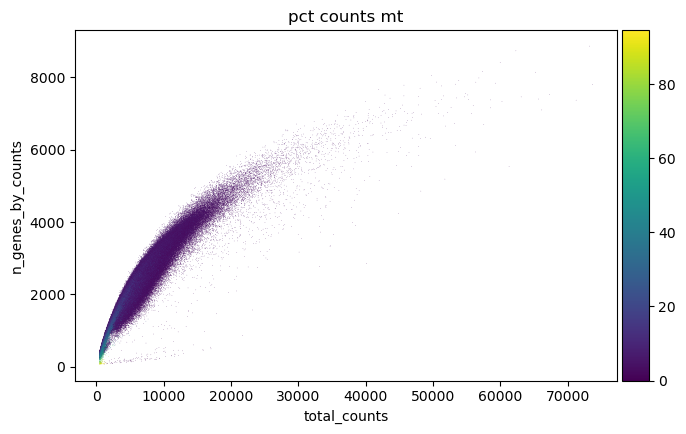

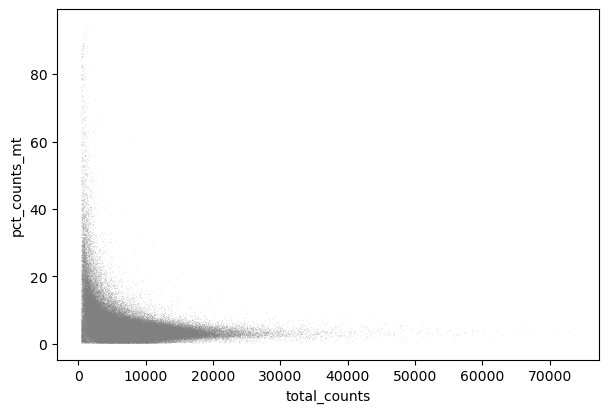

In [9]:
# Relación entre total_counts y n_genes_by_counts coloreada por porcentaje mitocondrial
sc.pl.scatter(
    adata,
    x='total_counts',
    y='n_genes_by_counts',
    color='pct_counts_mt'
)

# Relación entre pct_counts_mt y total_counts (se mantiene)
sc.pl.scatter(
    adata,
    x='total_counts',
    y='pct_counts_mt'
)

## 5. Definición de filtros de QC

- Se fijan umbrales **explícitos y ajustables**:

  - `MIN_GENES  = 500`
  - `MAX_GENES  = 6000`
  - `MIN_COUNTS = 1000`
  - `MAX_COUNTS = 50000`
  - `MAX_PCT_MT = 20.0`

- Se construye una máscara booleana con estas condiciones sobre:
  - `n_genes_by_counts`,
  - `total_counts`,
  - `pct_counts_mt`.
- **Importante:** `scrublet_predicted_doublet` **no** entra en la máscara en este notebook; se conserva para revisar más adelante junto con los marcadores.
- Se reportan:
  - nº de células antes y después del filtrado,
  - nº y proporción de células eliminadas.
- Se crea `adata_qc = adata[mask].copy()` y se vuelven a visualizar las
  métricas de QC tras el filtrado (violin plots).

In [10]:
# UMBRALES DE QC (DECIDIDOS A PARTIR DE LAS FIGURAS)

MIN_GENES = 500          # mínimo genes detectados por célula
MAX_GENES = 6000         # máximo genes detectados por célula
MIN_COUNTS = 1000        # mínimo total de cuentas por célula
MAX_COUNTS = 50000       # máximo total de cuentas por célula
MAX_PCT_MT = 20.0        # máximo porcentaje de cuentas mitocondriales

print("Umbrales de QC utilizados:")
print(f"- MIN_GENES  = {MIN_GENES}")
print(f"- MAX_GENES  = {MAX_GENES}")
print(f"- MIN_COUNTS = {MIN_COUNTS}")
print(f"- MAX_COUNTS = {MAX_COUNTS}")
print(f"- MAX_PCT_MT = {MAX_PCT_MT}")

# Creamos una máscara booleana para las células que pasan QC
obs = adata.obs.copy()
mask = np.ones(adata.n_obs, dtype=bool)

# Filtros de genes
mask &= obs["n_genes_by_counts"] >= MIN_GENES
mask &= obs["n_genes_by_counts"] <= MAX_GENES

# Filtros de counts
mask &= obs["total_counts"] >= MIN_COUNTS
mask &= obs["total_counts"] <= MAX_COUNTS

# Filtro de porcentaje mitocondrial
mask &= obs["pct_counts_mt"] <= MAX_PCT_MT

# IMPORTANTE: en esta etapa NO filtramos aún por doublets Scrublet.
# La información de scrublet_predicted_doublet se conserva en adata.obs
# para revisarla junto con marcadores en etapas de anotación más avanzadas.

# Resumen de cuántas células se conservan
n_before = adata.n_obs
n_after = int(mask.sum())
print(f"\nCélulas antes del filtrado: {n_before}")
print(f"Células después del filtrado (solo QC técnico): {n_after}")
print(f"Células filtradas: {n_before - n_after}")
print(f"Proporción de células conservadas: {n_after / n_before:.3f}")

# Subconjunto de adata con solo las células que pasan QC
adata_qc = adata[mask].copy()  # copy() para desvincular de adata original

print("\nObjeto después de QC (sin filtrar doublets todavía):")
print(adata_qc)

Umbrales de QC utilizados:
- MIN_GENES  = 500
- MAX_GENES  = 6000
- MIN_COUNTS = 1000
- MAX_COUNTS = 50000
- MAX_PCT_MT = 20.0

Células antes del filtrado: 231953
Células después del filtrado (solo QC técnico): 225944
Células filtradas: 6009
Proporción de células conservadas: 0.974

Objeto después de QC (sin filtrar doublets todavía):
AnnData object with n_obs × n_vars = 225944 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'total_counts_from_X', 'n_genes_from_X', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
  

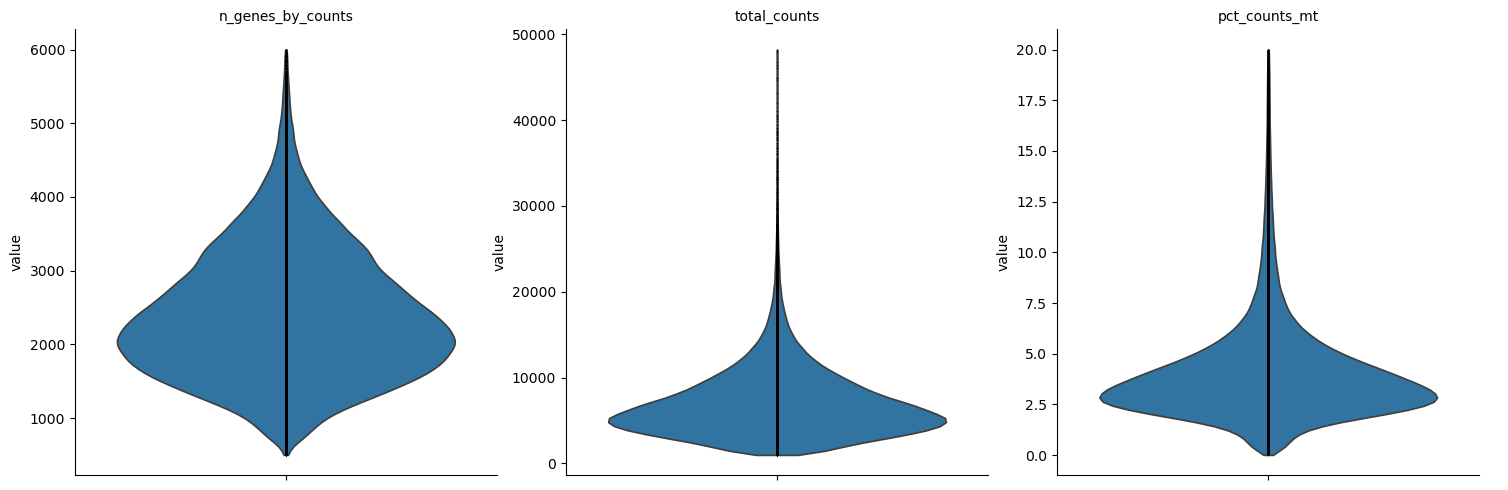

In [11]:
# Violin plots después del QC (usando todas las células que pasan QC)
sc.pl.violin(
    adata_qc,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.0,
    multi_panel=True
)

## 6. Guardado del objeto tras QC

- Antes de guardar, si existe, se elimina `adata_qc.raw` (se recreará después
  de la normalización para evitar conflictos).
- Se guarda el objeto filtrado en:

  - `data_processed/TFM_CIRRHOSIS_afterQC.h5ad`

- El archivo original `TFM_CIRRHOSIS_merged.h5ad` **no se sobrescribe**.
- `TFM_CIRRHOSIS_afterQC.h5ad` será la entrada estándar para los notebooks
  de normalización, HVG e integración.

In [12]:
# Limpieza de .raw antes de guardar (evitar problemas con columnas reservadas)
if adata_qc.raw is not None:
    print("Eliminando atributo .raw de adata_qc antes de guardar (se recreará más adelante tras la normalización).")
    adata_qc.raw = None
else:
    print("adata_qc.raw ya es None.")

Eliminando atributo .raw de adata_qc antes de guardar (se recreará más adelante tras la normalización).


In [13]:
# Guardado del objeto filtrado tras QC
qc_output_path = CONFIG["DATA_PROCESSED_DIR"] / "TFM_CIRRHOSIS_afterQC.h5ad"

adata_qc.write_h5ad(qc_output_path)

print(f"Objeto filtrado guardado en:\n{qc_output_path}")

Objeto filtrado guardado en:
D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\TFM_CIRRHOSIS_afterQC.h5ad


## 7. Resumen de este notebook

- Carga el dataset principal `TFM_CIRRHOSIS_merged.h5ad` y verifica que `adata.X`
  son counts coherentes con las métricas tipo Seurat (`nCount_RNA`, `nFeature_RNA`).
- Calcula métricas de QC por célula:
  - `n_genes_by_counts`,
  - `total_counts`,
  - `pct_counts_mt` (a partir de genes `MT-`).
- Explora gráficamente estas métricas y define umbrales de QC conservadores.
- Aplica un filtrado técnico basado solo en genes, counts y %MT
  (sin tocar todavía Scrublet ni anotaciones biológicas).
- Genera y guarda `TFM_CIRRHOSIS_afterQC.h5ad` como punto de partida limpio
  para los pasos posteriores del pipeline.

## Comentarios

- `adata.X` se comporta como **raw counts**, consistente con lo esperado tras
  el traspaso desde Seurat.
- Se detectan ~una decena de genes mitocondriales `MT-` y se usan para
  calcular `pct_counts_mt`.
- El filtrado elimina solo una fracción pequeña de células (≈2–3 %), coherente
  con un objeto ya prefiltrado en un pipeline previo.
- Las distribuciones antes y después del QC (genes, counts, %MT) son típicas
  de un dataset de PBMC razonable y respaldan los umbrales escogidos.